<a href="https://colab.research.google.com/github/leoclementliao/colab-yolov3/blob/master/yolov3_s2_Train_t2_warmUpLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/opt/bin/nvidia-smi

Thu Apr 16 16:21:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
## git yolo3_tf2 and pip libraries
# !git clone https://github.com/zzh8829/yolov3-tf2
!git clone https://github.com/leoclementliao/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

## Copy tfrecord dataset
%cp -r /content/drive/My\ Drive/Colab\ Notebooks/YoloV3/data /content/yolov3-tf2/data

## Download yolov3 weight (12 minutes)
%cp -r /content/drive/My\ Drive/Colab\ Notebooks/YoloV3/models/yolov3.weights /content/yolov3-tf2/data/

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 341, done.
remote: Total 341 (delta 0), reused 0 (delta 0), pack-reused 341
Receiving objects: 100% (341/341), 4.16 MiB | 36.11 MiB/s, done.
Resolving deltas: 100% (198/198), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 28.7MB 111kB/s 
     |████████████████████████████████| 3.9MB 45.3MB/s 
     |████████████████████████████████| 450kB 61.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=199d5ecbd42963bb22b2739855479104c1fcda0684155d62bb62318e9af7725f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.

In [7]:
## Training parameters
epochs = 30
batch_size = 16
learning_rate = 3e-4
image_size = 416
weights_dir = '/content/yolov3-tf2/data/yolov3.weights'
checkpoint_dir = '/content/yolov3-tf2/checkpoints/yolov3.tf'

## Dataset directory
train_dir = '/content/yolov3-tf2/data/data/voc2009_train.tfrecord'
val_dir = '/content/yolov3-tf2/data/data/voc2009_val.tfrecord'
classes_dir = "/content/yolov3-tf2/data/data/voc2009.name"

## Load class names
class_names = []
with open(classes_dir, "r") as f:
    for s in f:
        class_names.append(s[:-1])

num_classes = len(class_names)
print(f'{num_classes} classes')


20 classes


In [0]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard,
    LearningRateScheduler
)

from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
import yolov3_tf2.dataset as dataset
from yolov3_tf2.utils import draw_outputs, load_darknet_weights, freeze_all
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny, YoloLoss,
    yolo_anchors, yolo_anchor_masks,
    yolo_tiny_anchors, yolo_tiny_anchor_masks
)
from yolov3_tf2.utils import freeze_all
from google.colab.patches import cv2_imshow

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [0]:
## Fixed anchors
anchors = yolo_anchors
anchor_masks = yolo_anchor_masks

# Load model

In [0]:
## Load model
# !python convert.py


I0416 16:29:09.933503 139903805921152 utils.py:45] yolo_darknet/conv2d bn
I0416 16:29:09.940561 139903805921152 utils.py:45] yolo_darknet/conv2d_1 bn
I0416 16:29:09.947920 139903805921152 utils.py:45] yolo_darknet/conv2d_2 bn
I0416 16:29:09.952791 139903805921152 utils.py:45] yolo_darknet/conv2d_3 bn
I0416 16:29:09.957723 139903805921152 utils.py:45] yolo_darknet/conv2d_4 bn
I0416 16:29:09.962662 139903805921152 utils.py:45] yolo_darknet/conv2d_5 bn
I0416 16:29:09.967617 139903805921152 utils.py:45] yolo_darknet/conv2d_6 bn
I0416 16:29:09.972531 139903805921152 utils.py:45] yolo_darknet/conv2d_7 bn
I0416 16:29:09.977369 139903805921152 utils.py:45] yolo_darknet/conv2d_8 bn
I0416 16:29:09.982390 139903805921152 utils.py:45] yolo_darknet/conv2d_9 bn
I0416 16:29:09.988837 139903805921152 utils.py:45] yolo_darknet/conv2d_10 bn
I0416 16:29:09.994274 139903805921152 utils.py:45] yolo_darknet/conv2d_11 bn
I0416 16:29:10.000885 139903805921152 utils.py:45] yolo_darknet/conv2d_12 bn
I0416 16:29

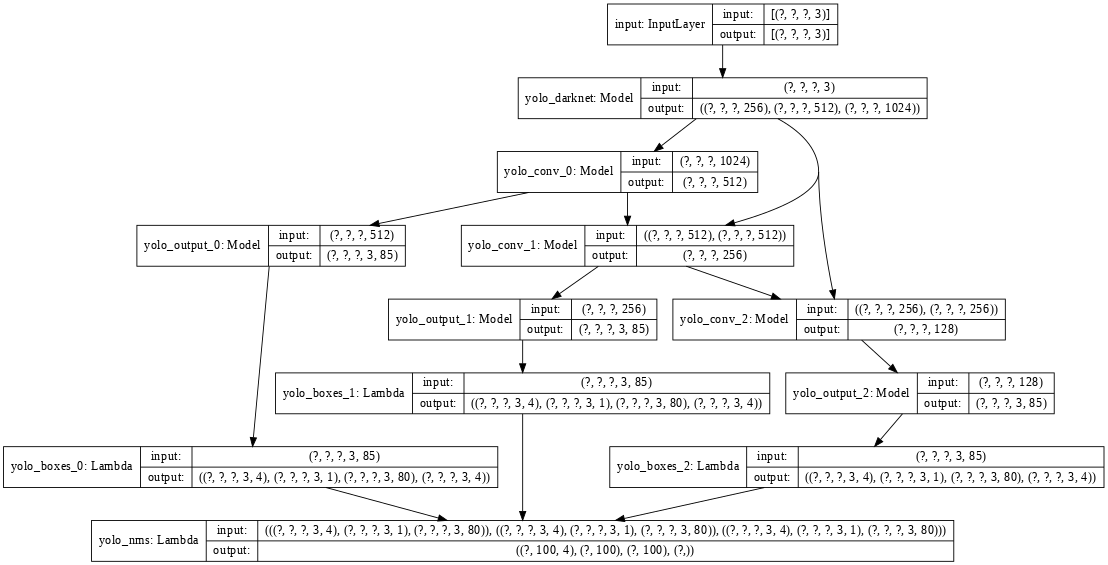

In [9]:
## Load model and save checkpoint files (convert pretrain model weight)
model_pretrained = YoloV3(classes=80) # The pretrain model is on coco dataset
load_darknet_weights(model_pretrained, weights_dir, tiny=False)
model_pretrained.save_weights(checkpoint_dir)

## Visualisation model
tf.keras.utils.plot_model(model_pretrained, show_shapes=True, dpi=64)

In [0]:
## Load darknet weight in the model
model = YoloV3(size=image_size, classes=num_classes, training=True,)

## Transfer learning
model.get_layer('yolo_darknet').set_weights(
                model_pretrained.get_layer('yolo_darknet').get_weights())
# freeze_all(model.get_layer('yolo_darknet'))



In [33]:
learning_rate**(np.arange(epochs)/100)

array([1.        , 0.92208554, 0.85024175, 0.78399562, 0.72291103,
       0.66658581, 0.61464914, 0.56675908, 0.52260035, 0.48188223,
       0.44433664, 0.40971639, 0.37779356, 0.34835798, 0.32121586,
       0.2961885 , 0.27311113, 0.25183183, 0.23221049, 0.21411793,
       0.19743505, 0.182052  , 0.16786752, 0.15478821, 0.14272797,
       0.1316074 , 0.12135328, 0.11189811, 0.10317963, 0.09514044])

Text(0, 0.5, 'lr')

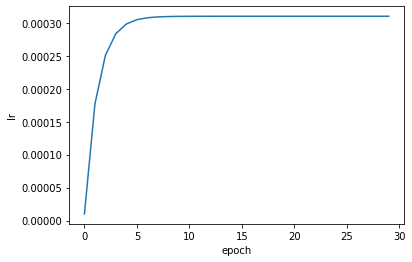

In [44]:
# def lr_schedule(epoch):
#     lr = learning_rate
#     lr = lr-0.5*(1+np.cos((epoch/epochs)*np.pi))*lr
#     # print('Learning rate: ', lr)
#     return lr
def lr_schedule(epoch):
    lr = learning_rate*(1-learning_rate**(epoch/10))+1e-5
    return lr
epochs=30
lrs = lr_schedule(np.arange(epochs))
plt.figure()
plt.plot(np.arange(epochs), lrs)
plt.xlabel('epoch')
plt.ylabel('lr')


In [0]:
# def lr_schedule(epoch):
    
#     lr = 1e-3
    
#     lr = 0.5*(1+np.cos((epoch/epochs)*np.pi))*lr
#     print('Learning rate: ', lr)
#     return lr
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

optimizer = tf.keras.optimizers.Adam(lr=lr_schedule(0), amsgrad=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=f'loss', 
                                            patience=3, verbose=1,
                                            factor=0.5, min_lr=1e-5)

In [0]:
loss = [YoloLoss(anchors[mask], classes=num_classes) for mask in anchor_masks]

model.compile(optimizer=optimizer, loss=loss)

callbacks = [
    learning_rate_reduction,
    lr_scheduler,
    # EarlyStopping(patience=3, verbose=1),
    # ModelCheckpoint('/content/yolov3-tf2/checkpoints/yolov3_train_{epoch}.tf',
    #                 verbose=1, save_weights_only=True),
    # TensorBoard(log_dir='logs')
]


# Data preparation

In [48]:
train_dataset = load_tfrecord_dataset(train_dir, classes_dir, size=image_size)
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (
    dataset.transform_images(x, image_size),
    dataset.transform_targets(y, anchors, anchor_masks, image_size)))
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.repeat()


val_dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
    dataset.transform_images(x, image_size),
    dataset.transform_targets(y, anchors, anchor_masks, image_size)))

train_dataset

<RepeatDataset shapes: ((None, 416, 416, 3), ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6), (None, 52, 52, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

In [0]:
def resize_image(s, L):
    s = tf.image.resize(s,
                        tf.constant([L,L]),
                        # method=tf.image.ResizeMethod.BICUBIC,
                        # antialias=True
                            )
    return s

def transform_image(s, size):
    s = tf.image.resize(s, (size, size))
    s = s / 255
    return s

def random_crop(s):
    s = resize_image(s, L=int(IMG_SIZE*1.2))
    s = tf.image.random_crop(s, [batch_size, IMG_SIZE, IMG_SIZE, N_CHANNELS])
    return s

def random_flip(s):
    if tf.random.uniform([1])[0]<0.5:
        s = tf.image.flip_left_right(s)
    return s

def color_jitter(s):
    s = tf.image.adjust_saturation(s, tf.random.uniform([1], 0.5,1.5)[0]) # saturation from 0.5 to 1.5
    s = tf.image.adjust_brightness(s, tf.random.uniform([1], -0.5, 0.5)[0]) # brightness from -0.4(dark) to 0.4(light)
    s = tf.clip_by_value(s, 0, 1)
    return s


## mixup v3  
def mix_up(s, b):
    alpha=1
    lamA = np.random.beta(alpha, alpha, [batch_size,1])
    lamB = 1-lamA
    ## Reorder according to permutation
    perm = tf.random.shuffle(tf.range(batch_size))
    sm = tf.gather(s, perm, axis=0)
    bm1 = tf.gather(b['dense_1'], perm, axis=0)
    bm2 = tf.gather(b['dense_2'], perm, axis=0)
    bm3 = tf.gather(b['dense_3'], perm, axis=0)

    b_out = {}
    s = lamA.reshape([-1,1,1,1])*s+lamB.reshape([-1,1,1,1])*sm
    b_out[output_1] = lamA*tf.cast(b[output_1], dtype='float32')+lamB*tf.cast(bm1, dtype='float32')
    b_out[output_2] = lamA*tf.cast(b[output_2], dtype='float32')+lamB*tf.cast(bm2, dtype='float32')
    b_out[output_3] = lamA*tf.cast(b[output_3], dtype='float32')+lamB*tf.cast(bm3, dtype='float32')
    
    return s, b_out

In [0]:
@tf.function
def mapped_function(s,b):
    if tf.random.uniform([1])[0]<0.75:
        # s = transform_image(s, FLAGS.size)
        # s = random_crop(s)  
        # s = random_flip(s)
        s = color_jitter(s)
        # s = add_mask(s)
    else :
        # s = transform_image(s, FLAGS.size)
        # s = random_crop(s)  
        # s = random_flip(s)
        s = color_jitter(s)
    return s,b

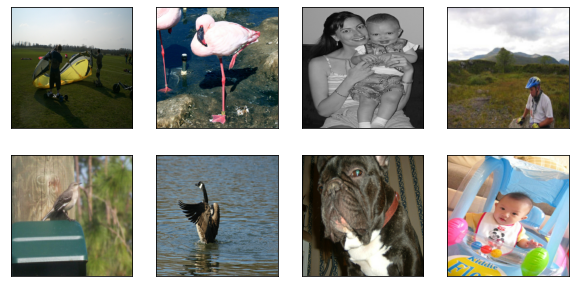

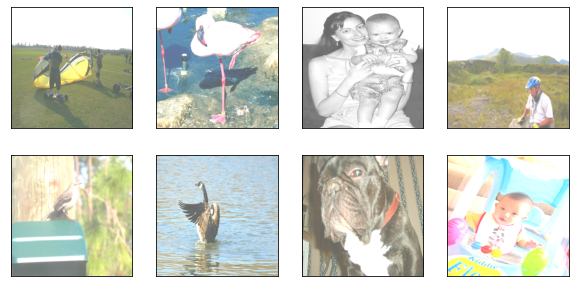

In [51]:
X_examples = list(train_dataset.take(2).as_numpy_iterator())[0][0]
y_examples = list(train_dataset.take(2).as_numpy_iterator())[0][1]
# image_examples = reshape_image(X_examples)
# image_examples = resize_image(image_examples)
image_examples = X_examples
plt.figure(figsize=(10,5))
for i in range(8):
    image_plot = np.array(image_examples[i])
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_plot, cmap=plt.cm.binary)
plt.show()

image_examples, target_examples = mapped_function(X_examples,y_examples)
plt.figure(figsize=(10,5))
for i in range(8):
    image_plot = np.array(image_examples[i])
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_plot, cmap=plt.cm.binary)
plt.show()


# Train

In [57]:
history = model.fit(train_dataset.map(mapped_function,num_parallel_calls=tf.data.experimental.AUTOTUNE),
                    validation_data=val_dataset,
                    steps_per_epoch= 3480// batch_size,
                    validation_steps = 448//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    )
trained_checkpoint_dir = '/content/yolov3-tf2/checkpoints/yolov3_train.tf'
model.save_weights(trained_checkpoint_dir)

Train for 217 steps, validate for 28 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
217/217 [==============================] - 167s 772ms/step - loss: 2284.3326 - yolo_output_0_loss: 62.6958 - yolo_output_1_loss: 262.0563 - yolo_output_2_loss: 1948.8601 - val_loss: 2031.4291 - val_yolo_output_0_loss: 82.1779 - val_yolo_output_1_loss: 238.6811 - val_yolo_output_2_loss: 1699.8490

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00017669900835885207.
Epoch 2/30
217/217 [==============================] - 150s 691ms/step - loss: 437.8718 - yolo_output_0_loss: 20.3719 - yolo_output_1_loss: 40.8200 - yolo_output_2_loss: 365.3821 - val_loss: 248.0461 - val_yolo_output_0_loss: 18.9896 - val_yolo_output_1_loss: 21.7082 - val_yolo_output_2_loss: 195.9153

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002507694854249554.
Epoch 3/30
217/217 [==============================] - 151s 694ms/step - loss: 145.2599 - yolo_output_0_loss

In [58]:
yolo = YoloV3(classes=num_classes)
yolo.load_weights(trained_checkpoint_dir).expect_partial()
# yolo.load_weights('/content/yolov3-tf2/checkpoints/yolov3_train_3.tf').expect_partial()


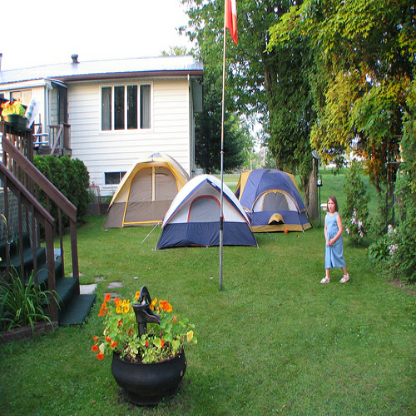

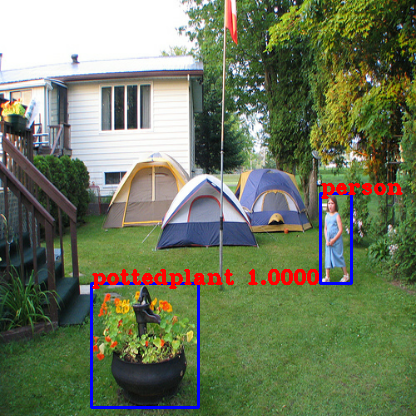

In [59]:
# from google.colab.patches import cv2_imshow
i = 141

dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
for image, labels in dataset.take(i):
    boxes = []
    scores = []
    classes = []
    img = tf.expand_dims(image, 0)
    img = transform_images(img, FLAGS.size)
    boxes, scores, classes, nums = yolo(img)
    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2_imshow(img)

dataset = load_tfrecord_dataset(val_dir, classes_dir, size=image_size)
for image, labels in dataset.take(i):
    boxes = []
    scores = []
    classes = []
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue
        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2_imshow(img)

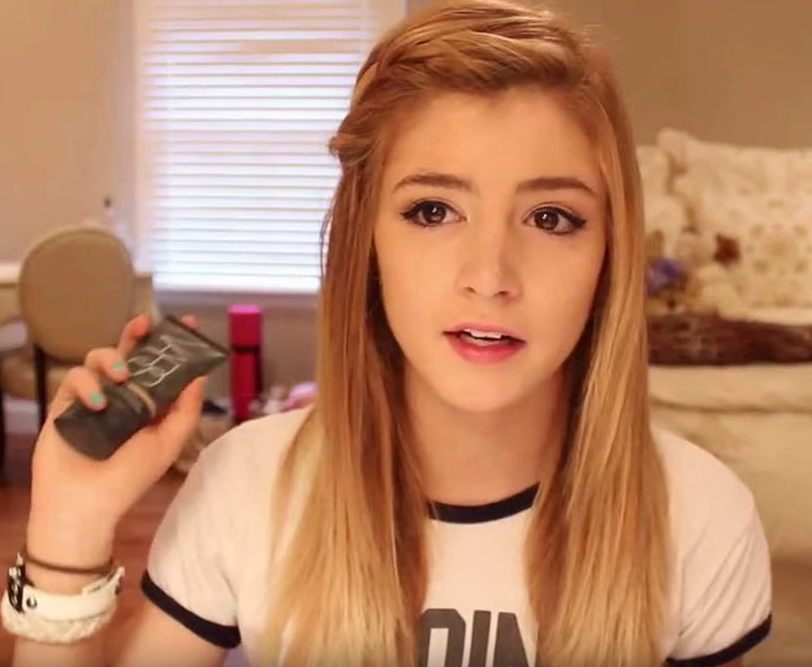

In [61]:
FLAGS.image = '/content/yolov3-tf2/data/girl.png'
# FLAGS.image = '/content/yolov3-tf2/data/meme2.jpeg'

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

boxes, scores, classes, nums = yolo(img)

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

cv2_imshow(img)

In [0]:
# YOLOV3_LAYER_LIST = [
#     'yolo_darknet',
#     'yolo_conv_0',
#     'yolo_output_0',
#     'yolo_conv_1',
#     'yolo_output_1',
#     'yolo_conv_2',
#     'yolo_output_2',
# ]

# YOLOV3_TINY_LAYER_LIST = [
#     'yolo_darknet',
#     'yolo_conv_0',
#     'yolo_output_0',
#     'yolo_conv_1',
#     'yolo_output_1',
# ]

# def load_darknet_weights(model, weights_file, tiny=False):
#     wf = open(weights_file, 'rb')
#     major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

#     if tiny:
#         layers = YOLOV3_TINY_LAYER_LIST
#     else:
#         layers = YOLOV3_LAYER_LIST

#     for layer_name in layers:
#         sub_model = model.get_layer(layer_name)
#         for i, layer in enumerate(sub_model.layers):
#             if not layer.name.startswith('conv2d'):
#                 continue
#             batch_norm = None
#             if i + 1 < len(sub_model.layers) and \
#                     sub_model.layers[i + 1].name.startswith('batch_norm'):
#                 batch_norm = sub_model.layers[i + 1]

#             logging.info("{}/{} {}".format(
#                 sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

#             filters = layer.filters
#             size = layer.kernel_size[0]
#             in_dim = layer.input_shape[-1]

#             if batch_norm is None:
#                 conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
#             else:
#                 # darknet [beta, gamma, mean, variance]
#                 bn_weights = np.fromfile(
#                     wf, dtype=np.float32, count=4 * filters)
#                 # tf [gamma, beta, mean, variance]
#                 bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

#             # darknet shape (out_dim, in_dim, height, width)
#             conv_shape = (filters, in_dim, size, size)
#             conv_weights = np.fromfile(
#                 wf, dtype=np.float32, count=np.product(conv_shape))
#             # tf shape (height, width, in_dim, out_dim)
#             conv_weights = conv_weights.reshape(
#                 conv_shape).transpose([2, 3, 1, 0])

#             if batch_norm is None:
#                 layer.set_weights([conv_weights, conv_bias])
#             else:
#                 layer.set_weights([conv_weights])
#                 batch_norm.set_weights(bn_weights)

#     # assert len(wf.read()) == 0, 'failed to read all data'
#     wf.close()

In [0]:
output_1, output_2, output_3 = 'yolo_output_0', 'yolo_output_1', 'yolo_output_2'
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10)) 
    plt.plot(np.arange(0, epoch), his.history['loss'], 'k', label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['val_loss'], 'k--', label='val_loss')
    plt.plot(np.arange(0, epoch), his.history[f'{output_1}_loss'], 'r', label=f'train_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_2}_loss'], 'g', label=f'train_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_3}_loss'], 'b', label=f'train_{output_3}')
    
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_1}_loss'], 'r--', label=f'val_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_2}_loss'], 'g--', label=f'val_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_3}_loss'], 'b--', label=f'val_{output_3}')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10))
    plt.yticks(np.arange(0.1,1.05,0.01))
    plt.xticks(np.arange(0,61,1))
    plt.plot(np.arange(0, epoch), his.history[f'{output_1}_accuracy'], 'r', label=f'train_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_2}_accuracy'], 'g', label=f'train_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_3}_accuracy'], 'b', label=f'train_{output_3}')
    
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_1}_accuracy'], 'r--', label=f'val_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_2}_accuracy'], 'g--', label=f'val_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_3}_accuracy'], 'b--', label=f'val_{output_3}')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [0]:
# plot_acc(history, epochs, 'Training Dataset: ')
plot_loss(history, epochs, 'Training Dataset: ')

plt.figure()
plt.plot(history.epoch, history.history['lr'])